### plot z drift correlation with reference image across sessions using phase correlation

In [1]:
import os
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
import pickle
from matplotlib.gridspec import GridSpec

import sys
sys.path.append("..")
from utils_image import compute_zpos_sp
from utils_analysis import plot_trajectory, getLinearSpeed, getAngularSpeed


#### 1, load z stacks and ops

In [2]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023/"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
RegTif_folder = os.path.join(processed_datafolder, 'reg_tif')

#load ops
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops = ops.item()

#load meanstacks.npy from datafolder, DP_exp
meanstacks = np.load(os.path.join(datafolder, "DP_exp", "meanstacks.npy"))

#### 2, get the correlation matrix of one tiff with z stacks

In [ ]:

#load Registered tiffs from suite2p folder
filenames = ['file000_chan0.tif']
# Load the registered tiff image
regFrames = []
for filename in filenames:
    with tf.TiffFile(os.path.join(RegTif_folder, filename)) as tif:
        for page in tif.pages:
            image = page.asarray()
            #transpose the image because the image is rotated after suite2p processing
            regFrames.append(image.T)
regFrames = np.array(regFrames)
            
#perform phase correlation
_, _, corrMatrix = compute_zpos_sp(meanstacks, regFrames, ops)

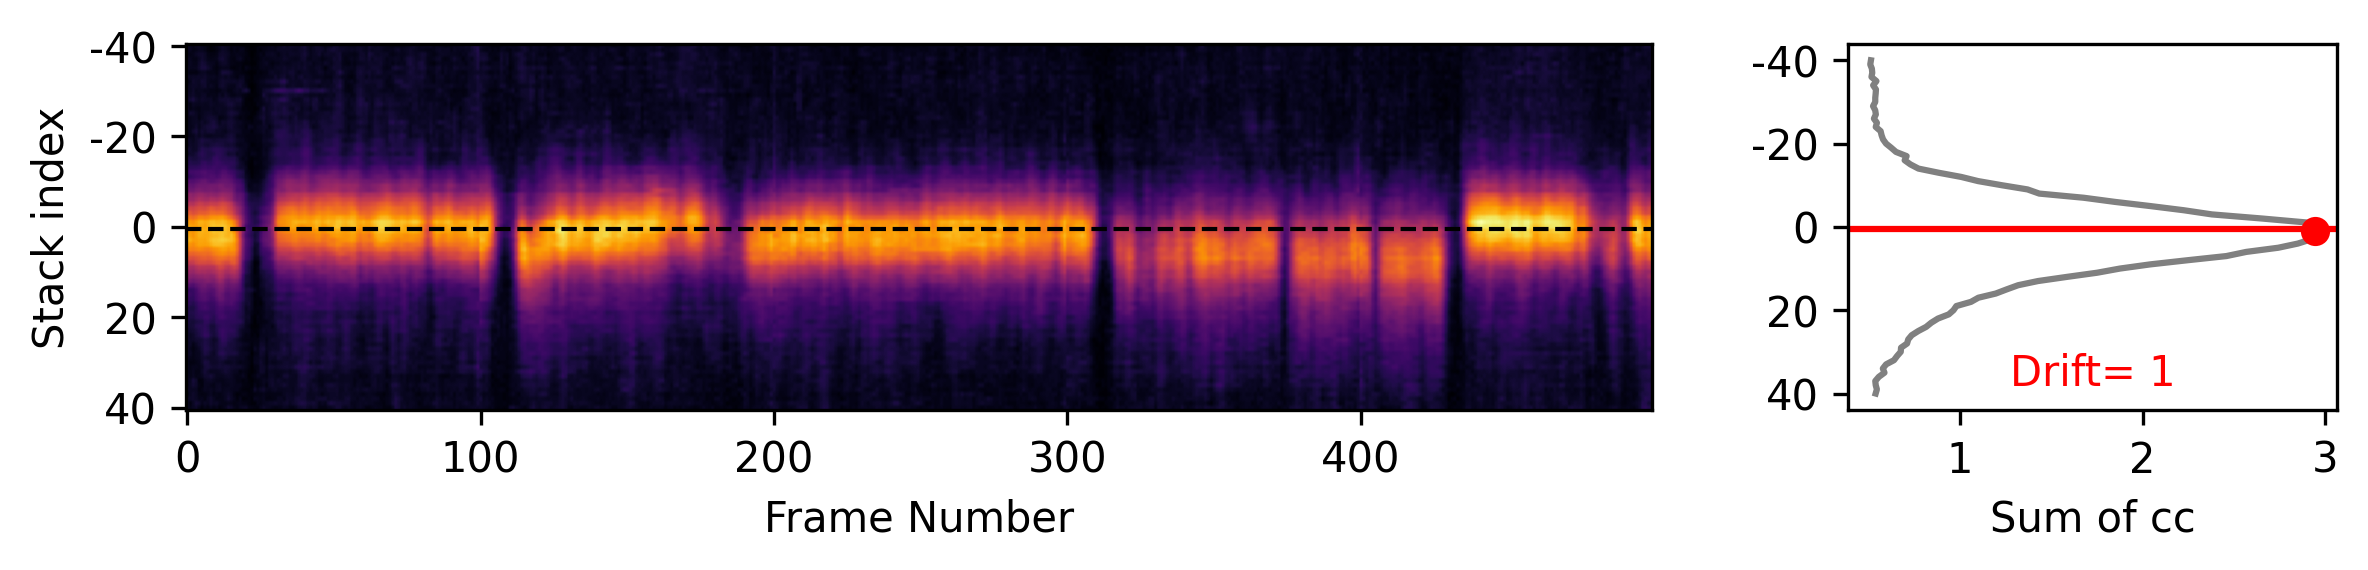

In [8]:
# plot the correlation matrix
fig = plt.figure(figsize=(8, 2),dpi=300)

nplanes, nframes = corrMatrix.shape

#plot 1 occupy 3/4 of the canvas and plot 2 occupy 1/4 of the canvas
gs = GridSpec(1, 2, width_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0, 0])  
ax1.imshow(corrMatrix, aspect='auto',cmap='inferno')
ax1.set_xlabel('Frame Number')
ax1.set_ylabel('Stack index')
#recenter the y label with zero representing the middle stack
ax1.set_yticks(np.arange(0, nplanes, 20))    
ax1.set_yticklabels(np.arange(0, nplanes, 20)-int(nplanes/2))
#add a red line to separate the two blocks
ax1.axhline(y=nplanes/2, color='black', linestyle='--', linewidth=1)

#do the second plot
ax2 = fig.add_subplot(gs[0, 1])
#sum the correlation matrix along the frame axis
sumCorrMatrix = np.sum(corrMatrix, axis=1)
#plot with a grey line
ax2.plot(sumCorrMatrix, np.arange(0, nplanes), color='grey')
ax2.set_xlabel('Sum of cc')
ax2.set_yticks(np.arange(0, nplanes, 20))
#reset y label every 5 stacks and subtratc the middle stack index
ax2.set_yticklabels(np.arange(0, nplanes, 20)-int(nplanes/2))
#flip y axis
ax2.set_ylim(ax2.get_ylim()[::-1])
#add a red line to separate the two blocks
ax2.axhline(y=nplanes/2, color='r', linestyle='-')
#find the peak of the sumCorrMatrix and plot it with a red dot
maxIndex = np.argmax(sumCorrMatrix)
ax2.plot(sumCorrMatrix[maxIndex], maxIndex, 'ro')
#get the shift amount
shiftamount = maxIndex - int(nplanes/2)   
#add a text and the right bottom corner to show the shift amount on plot 2
ax2.text(0.5, 0.1, 'Drift= ' + str(shiftamount), horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, color='r')

plt.tight_layout()
# Remove the some empty space between the subplots
plt.subplots_adjust(wspace=0.2)

#### remind myself that why I need to take the transpose of registered image

In [ ]:
#get mean of regFrames
meanRegFrames = np.mean(regFrames, axis=0)
plt.figure(figsize=(10,10))
plt.subplot(121)
#put row as column and column as row of meanRegFrames
plt.imshow(meanRegFrames.T, cmap='gray')
plt.subplot(122)
plt.imshow(meanstacks[41,:,:], cmap='gray')

#### get correlation matrixes of all tiff files

In [3]:
binsize = 25
savefolder = os.path.join(datafolder, 'UnrotTiff/2D2P')
corrMatName = 'corrMatrix_binsize_' + str(binsize) + '.pkl'
#check if corrMatrix.pkl exists under savefolder
if os.path.isfile(os.path.join(savefolder, corrMatName)):
    with open(os.path.join(savefolder, corrMatName), 'rb') as f:
        all_corrMatrix = pickle.load(f)
else:
    #read all tif under the folder RegTif_folder 
    filenames = os.listdir(RegTif_folder)
    #sort the filenames by number
    filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #throw away the last filename because it might not be 500 frame in that tiff
    filenames = filenames[:-1]
    # Load the registered tiff image
    all_corrMatrix = {}
    for filename in filenames:
        print('processing: ' + filename)
        regFrames = []
        with tf.TiffFile(os.path.join(RegTif_folder, filename)) as tif:
            for page in tif.pages:
                image = page.asarray()
                #transpose the image because the image is rotated after suite2p processing
                regFrames.append(image.T)
        regFrames = np.array(regFrames)
        
        #bin every binsize frames and take the mean
        bin_regFrames = regFrames.reshape(-1, binsize, regFrames.shape[1], regFrames.shape[2]).mean(axis=1)
                
        #perform phase correlation
        _, _, corrMatrix = compute_zpos_sp(meanstacks, bin_regFrames, ops)
        
        #append the corrMatrix to all_corrMatrix
        all_corrMatrix[filename] = corrMatrix 
    
    #save the all_corrMatrix to pickle file
    with open(os.path.join(savefolder, corrMatName), 'wb') as f:
        pickle.dump(all_corrMatrix, f)

#for all elements in all_corrMatrix, concatenate them by the first dimension
corrMatrix = np.concatenate(list(all_corrMatrix.values()), axis=1)
nplanes, nframes = corrMatrix.shape

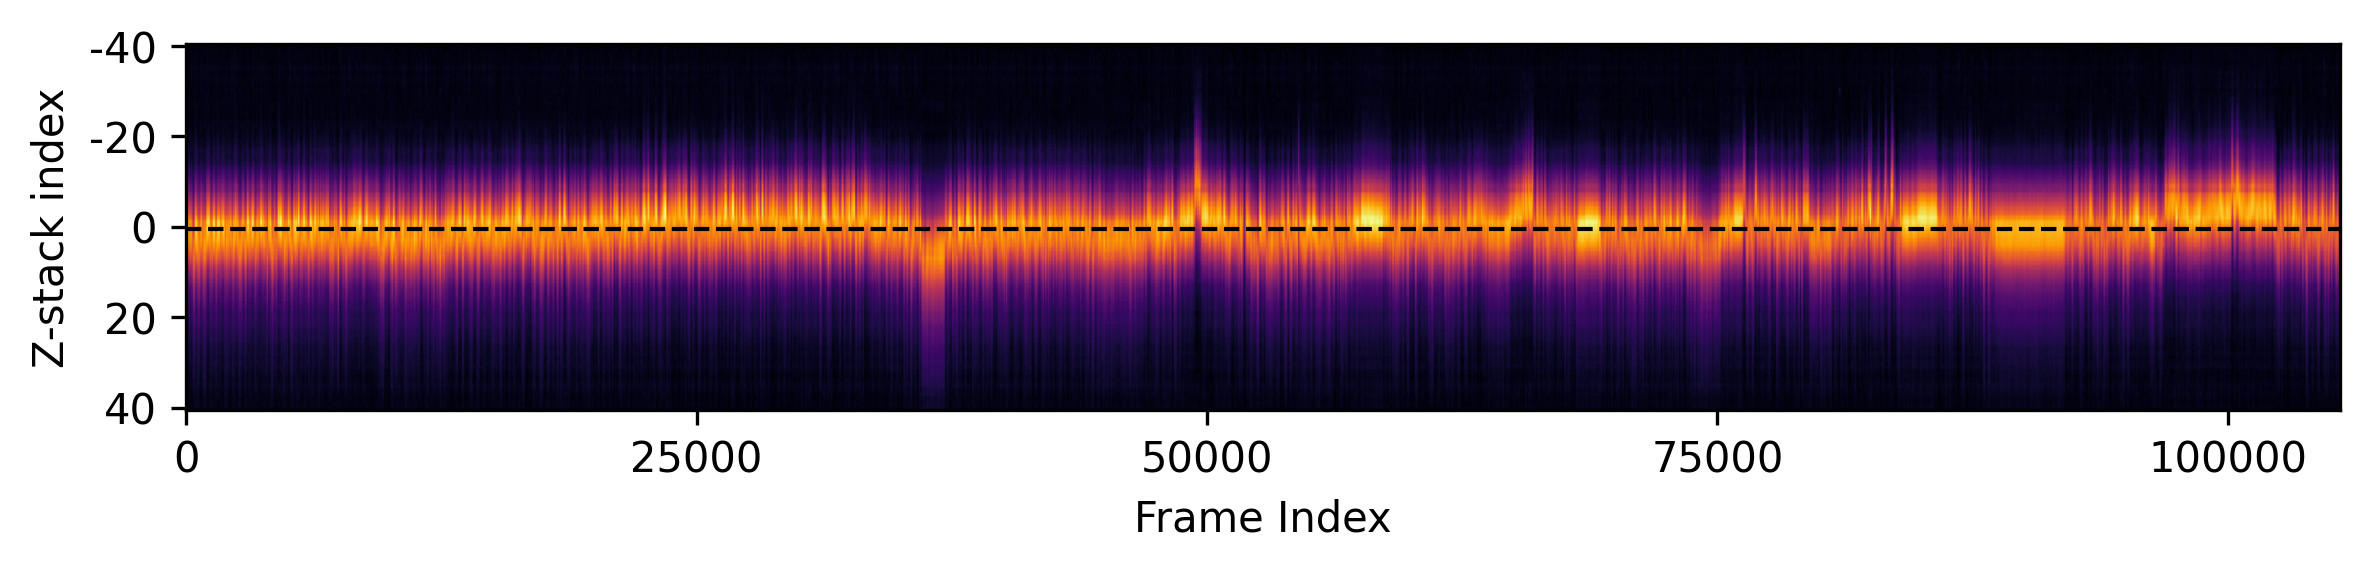

In [4]:
#for all elements in all_corrMatrix, concatenate them by the first dimension
corrMatrix = np.concatenate(list(all_corrMatrix.values()), axis=1)

fig, ax = plt.subplots(figsize=(8,2), dpi=300)

nplanes, nframes = corrMatrix.shape

ax.imshow(corrMatrix, aspect='auto',cmap='inferno')
ax.set_xlabel('Frame Index')
ax.set_ylabel('Z-stack index')
#set x ticks every 1000 frames
xticks = np.arange(0, nframes, 1000)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks*binsize)

#recenter the y label with zero representing the middle stack
ax.set_yticks(np.arange(0, nplanes, 20))    
ax.set_yticklabels(np.arange(0, nplanes, 20)-int(nplanes/2))
#add a red line to separate the two blocks
ax.axhline(y=nplanes/2, color='black', linestyle='--', linewidth=1)

plt.tight_layout()


#### load trajectory

In [77]:
filenamelist = ["00004", "00005", "00006", "00007", "00008", "00009", "00010", "00012", "00014", "00016", "00017", "00018"]

#if trajectory is already saved in pickle file, load it
if os.path.exists(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle')):
    with open(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle'), 'rb') as f:
        trajectory = pickle.load(f)
    allX = trajectory[0]
    allZ = trajectory[1]
    allTime = trajectory[2]
    allTheta = trajectory[3]
else:
    allX, allZ, allTime, allTheta, fig = plot_trajectory(datafolder, filenamelist)
    
#change allX and allZ from dictionary to np.array
Traj_x = np.concatenate(list(allX.values()))
Traj_z = np.concatenate(list(allZ.values()))
Theta = np.concatenate(list(allTheta.values()))
#change degree to radian]
Theta = Theta/180*np.pi

#normalize x and z to [0,1]
Traj_x = (Traj_x-np.min(Traj_x))/(np.max(Traj_x)-np.min(Traj_x))
Traj_z = (Traj_z-np.min(Traj_z))/(np.max(Traj_z)-np.min(Traj_z))


#concatenate the time stamps, a
# add 0.033 + the last element to make sure the time stamps at each boundary are not the same using for loop
for i in range(len(allTime)):
    #chnage allTime[i] to np.array
    allTime[i] = np.array(allTime[i])
    if i == 0:
        timestamps = allTime[i]
    else:
        timestamps = np.concatenate((timestamps, allTime[i]+timestamps[-1]+0.033))

#get the linear speed
linearspeed = getLinearSpeed(Traj_x, Traj_z, timestamps, boxcar_size=0)
#cut the speed to the same length
linearspeed = linearspeed[:nframes*binsize]
#every binsize data points, take the mean
linearspeed = linearspeed.reshape(-1, binsize).mean(axis=1)
            
#get the angular speed
angularspeed = getAngularSpeed(Theta, timestamps)  
#cut the angular_speed to the same length 
angularspeed = angularspeed[:nframes*binsize]
#every binsize data points, take the mean
angularspeed = angularspeed.reshape(-1, binsize).mean(axis=1)     

#### put correlation matrix and behavior data together

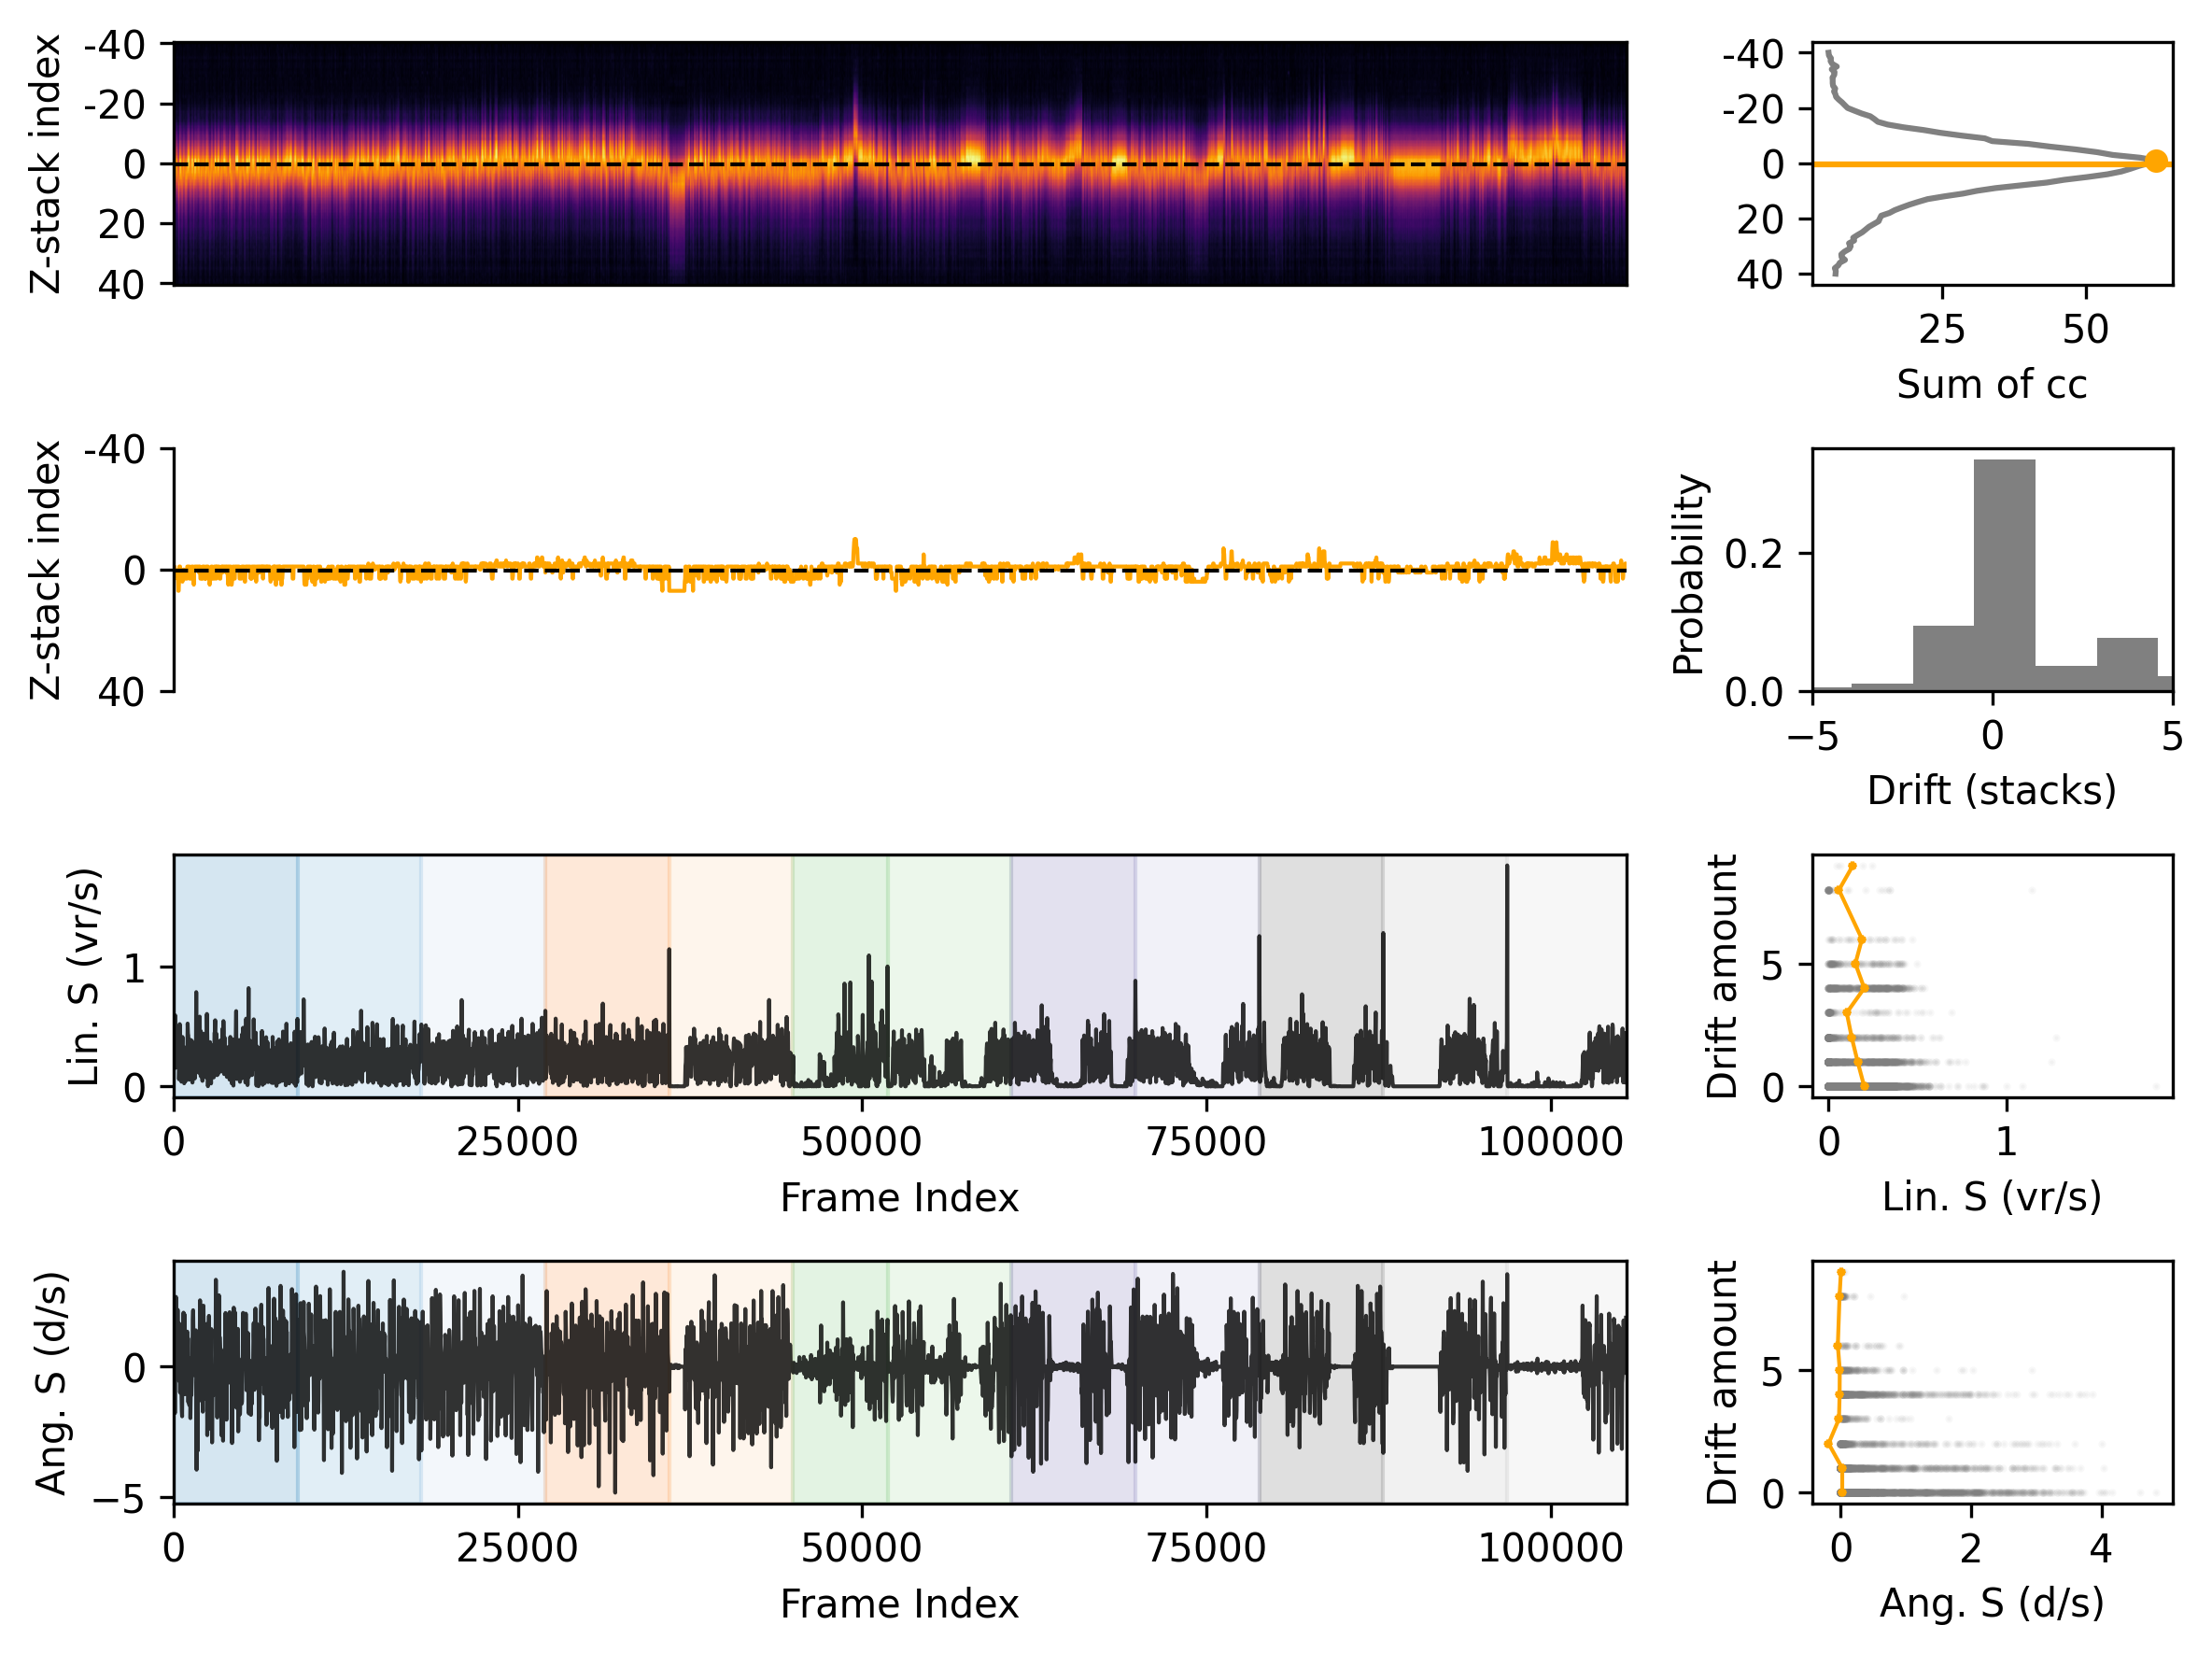

In [78]:
#two subplots using gridspec, one for correlation matrix and one for speed
fig = plt.figure(figsize=(8, 6),dpi=300)

labelsize = 10
ticksize = 8

gs = GridSpec(4, 4, height_ratios=[1,1, 1, 1], width_ratios=[1, 1, 1, 1])

driftcenter = int(nplanes/2)

###########################ax11###########################
ax11 = fig.add_subplot(gs[0, :3])
ax11.imshow(corrMatrix, aspect='auto',cmap='inferno')
#add a red line to separate the two blocks
ax11.axhline(y=nplanes/2, color='black', linestyle='--', linewidth=1)

#set xlim
ax11.set_xlim([0, nframes])
# #set x ticks every 1000 frames
# xticks = np.arange(0, nframes, 1000)
# ax1.set_xticks(xticks)
# ax1.set_xticklabels(xticks*binsize)
#set xticks off
ax11.set_xticks([])
ax11.set_ylabel('Z-stack index', fontsize=labelsize)
#recenter the y label with zero representing the middle stack
ax11.set_yticks(np.arange(0, nplanes, 20))    
ax11.set_yticklabels(np.arange(0, nplanes, 20)-driftcenter)


###########################ax12###########################
#do the second plot
ax12 = fig.add_subplot(gs[0, 3])
#sum the correlation matrix along the frame axis
sumCorrMatrix = np.sum(corrMatrix, axis=1)
#plot with a grey line
ax12.plot(sumCorrMatrix, np.arange(0, nplanes), color='grey')
ax12.set_xlabel('Sum of cc', fontsize=labelsize)
ax12.set_yticks(np.arange(0, nplanes, 20))
#reset y label every 5 stacks and subtratc the middle stack index
ax12.set_yticklabels(np.arange(0, nplanes, 20)-int(nplanes/2))
#flip y axis
ax12.set_ylim(ax12.get_ylim()[::-1])
#add a red line to separate the two blocks
ax12.axhline(y=nplanes/2, color='orange', linestyle='-')
#find the peak of the sumCorrMatrix and plot it with a red dot
maxIndex = np.argmax(sumCorrMatrix)
ax12.plot(sumCorrMatrix[maxIndex], maxIndex, color='orange', marker='o', markersize=5)
# #get the shift amount
# shiftamount = maxIndex - int(nplanes/2)   
# #add a text and the right bottom corner to show the shift amount on plot 2
# ax2.text(0.5, 0.1, 'Drift= ' + str(shiftamount), horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, color='r')

###########################ax21###########################
ax21 = fig.add_subplot(gs[1, :3])
#get the index of maximum value at each cloumn in corrMatrix
maxIndex = np.argmax(corrMatrix, axis=0)
#add a red dot at the maximum value in each column to the plot
ax21.plot(np.arange(0, nframes), maxIndex, color='orange', linestyle='-', linewidth=1)
#add a red line to separate the two blocks
ax21.axhline(y=nplanes/2, color='black', linestyle='--', linewidth=1)

#set xlim
ax21.set_xlim([0, nframes])
# #set x ticks every 1000 frames
# xticks = np.arange(0, nframes, 1000)
# ax2.set_xticks(xticks)
# ax2.set_xticklabels(xticks*binsize)
#set xticks off
ax21.set_xticks([])
ax21.set_ylabel('Z-stack index', fontsize=labelsize)
#recenter the y label with zero representing the middle stack
ax21.set_yticks(np.arange(0, nplanes, 40))    
ax21.set_yticklabels(np.arange(0, nplanes, 40)-driftcenter)
#flip y axis up and down
ax21.set_ylim(ax21.get_ylim()[::-1])
#set right top bottom axis off
ax21.spines['right'].set_visible(False)
ax21.spines['top'].set_visible(False)
ax21.spines['bottom'].set_visible(False)


############################ax22###########################
ax22 = fig.add_subplot(gs[1, 3])
drift = maxIndex- driftcenter+1
#plot the histogram of drift
ax22.hist(drift, bins=10, color='grey',density=True)
ax22.set_ylabel('Probability', fontsize=labelsize)
ax22.set_xlabel('Drift (stacks)', fontsize=labelsize)
#set x lim [-5,5]
ax22.set_xlim([-5,5])

############################ax31###########################
ax31 = fig.add_subplot(gs[2, :3])
#choose colormap when plot, equally sampled from tab20c accodring to the number of sessions
colors = plt.cm.tab20c(np.linspace(0, 1, len(allX)))

ax31.plot(linearspeed, linewidth=1, color='k', alpha=0.8)
#add shaeded area with different colors to mark different sessions
split_ind = np.cumsum([len(allTime[i])/binsize for i in range(len(allTime))])
#change each element in split_ind to int
split_ind = split_ind.astype(int)
#add 0 at the beginning 
split_ind = np.concatenate(([0], split_ind))
for i in range(len(allTime)):
    ax31.axvspan(split_ind[i], split_ind[i+1], alpha=0.2, color=colors[i])

#set x ticks every 1000 frames
xticks = np.arange(0, nframes, 1000)
ax31.set_xticks(xticks)
ax31.set_xticklabels(xticks*binsize)
#set xlim
ax31.set_xlim([0, nframes])
#xlabel and ylabel  
ax31.set_xlabel('Frame Index', fontsize=labelsize)
ax31.set_ylabel('Lin. S (vr/s)', fontsize=labelsize)


############################ax32###########################
ax32 = fig.add_subplot(gs[2, 3])
#plot absdrift (y) vs speed (x) as scatter plot
ax32.scatter(linearspeed, np.abs(drift), color='grey', s=1, alpha=0.05)

#for each value of np.abs(drift), find the mean of linearspeed
#first, find the unique values of np.abs(drift)
unique_drift = np.unique(np.abs(drift))
#then, find the mean of linearspeed for each unique value of np.abs(drift)
mean_linearspeed = np.array([np.mean(linearspeed[np.abs(drift)==i]) for i in unique_drift])
#plot the mean_linearspeed vs unique_drift as a orange * 
ax32.plot(mean_linearspeed, unique_drift, color='orange', marker='*', markersize=2, linewidth=1)

ax32.set_xlabel('Lin. S (vr/s)', fontsize=labelsize)
ax32.set_ylabel('Drift amount', fontsize=labelsize)


############################ax41###########################
ax41 = fig.add_subplot(gs[3, :3])
#choose colormap when plot, equally sampled from tab20c accodring to the number of sessions
colors = plt.cm.tab20c(np.linspace(0, 1, len(allX)))
ax41.plot(angularspeed, linewidth=1, color='k', alpha=0.8)
#add shaeded area with different colors to mark different sessions
split_ind = np.cumsum([len(allTime[i])/binsize for i in range(len(allTime))])
#change each element in split_ind to int
split_ind = split_ind.astype(int)
#add 0 at the beginning 
split_ind = np.concatenate(([0], split_ind))
for i in range(len(allTime)):
    ax41.axvspan(split_ind[i], split_ind[i+1], alpha=0.2, color=colors[i])

#set x ticks every 1000 frames
xticks = np.arange(0, nframes, 1000)
ax41.set_xticks(xticks)
ax41.set_xticklabels(xticks*binsize)
#set xlim
ax41.set_xlim([0, nframes])
#xlabel and ylabel  
ax41.set_xlabel('Frame Index', fontsize=labelsize)
ax41.set_ylabel('Ang. S (d/s)', fontsize=labelsize)

############################ax42###########################
ax42 = fig.add_subplot(gs[3, 3])
#plot absdrift (y) vs speed (x) as scatter plot
ax42.scatter(np.abs(angularspeed), np.abs(drift), color='grey', s=1, alpha=0.05)

#for each value of np.abs(drift), find the mean of linearspeed
#first, find the unique values of np.abs(drift)
unique_drift = np.unique(np.abs(drift))
#then, find the mean of linearspeed for each unique value of np.abs(drift)
mean_angularspeed = np.array([np.mean(angularspeed[np.abs(drift)==i]) for i in unique_drift])
#plot the mean_linearspeed vs unique_drift as a orange * 
ax42.plot(mean_angularspeed, unique_drift, color='orange', marker='*', markersize=2, linewidth=1)
ax42.set_xlabel('Ang. S (d/s)', fontsize=labelsize)
ax42.set_ylabel('Drift amount', fontsize=labelsize)

#tight_layout
plt.tight_layout()

#### correlating linear speed and angular speed

Text(0.5, 1.0, 'r=0.1593, p=0.0')

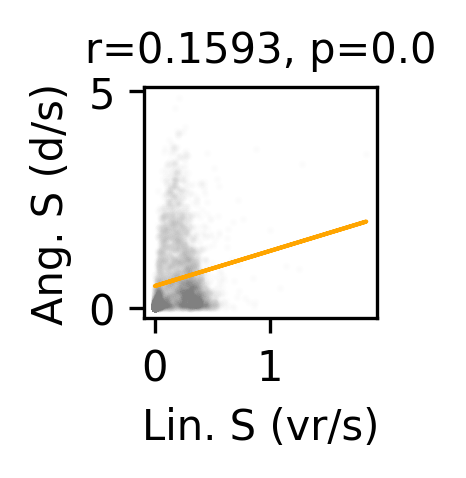

In [79]:
fig,ax = plt.subplots(figsize=(1,1), dpi=300)
#plot absdrift (y) vs speed (x) as scatter plot
ax.scatter(linearspeed, np.abs(angularspeed), color='grey', s=1, alpha=0.01)
#add an linear fit line
#fit a linear line to the data
fit = np.polyfit(linearspeed, np.abs(angularspeed), 1)
#plot the fit line
ax.plot(linearspeed, fit[0] * linearspeed + fit[1], color='orange', linewidth=1)
ax.set_xlabel('Lin. S (vr/s)', fontsize=labelsize)
ax.set_ylabel('Ang. S (d/s)', fontsize=labelsize)
#person correlation of x and y
import scipy.stats as stats
r, p = stats.pearsonr(linearspeed, np.abs(angularspeed))
#add r and p to show the correlation in title, keep 4 decimal places
ax.set_title('r=' + str(round(r,4)) + ', p=' + str(round(p,4)), fontsize=labelsize)

#### ccross correlation between z drift amount and linear speed

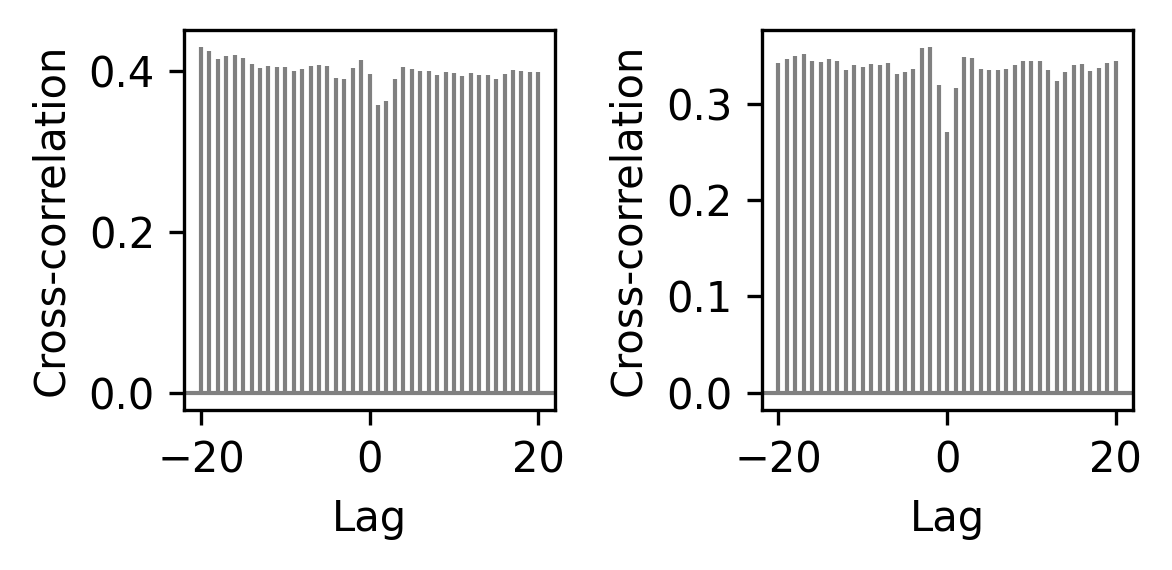

In [84]:
fig, axs = plt.subplots(1,2, figsize=(4,2), dpi=300)

#perform cross correlation between linearspeed, np.abs(drift), and plot the result


#second, perform cross correlation with lag = 10 frames, and plot the result
axs[0].xcorr(linearspeed, np.abs(drift), usevlines=True, maxlags=20, normed=True, lw=1, color='grey')
axs[0].set_xlabel('Lag', fontsize=labelsize)
axs[0].set_ylabel('Cross-correlation', fontsize=labelsize)

#second, perform cross correlation with lag = 10 frames, and plot the result
axs[1].xcorr(np.abs(angularspeed), np.abs(drift), usevlines=True, maxlags=20, normed=True, lw=1, color='grey')
axs[1].set_xlabel('Lag', fontsize=labelsize)
axs[1].set_ylabel('Cross-correlation', fontsize=labelsize)

plt.tight_layout()


    